<a href="https://colab.research.google.com/github/RadSpiral/certified_machine_unlearning/blob/main/new_logistic_ridge_n_p_scaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import scipy.linalg
import statsmodels.api as sm
from scipy.stats import gamma

def sample_b(p, C):
    # Step 1: Sample r ~ Gamma(p, scale=1/C)
    r = gamma.rvs(a=p, scale=1/C)

    # Step 2: Sample a unit vector u ~ Uniform(S^(p-1))
    u = np.random.randn(p)
    u /= np.linalg.norm(u)  # Normalize to unit sphere

    # Step 3: Scale the unit vector
    b = r * u
    return b

# Logistic Ridge Regression Functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss(beta, X, y, lambda_):
    n              = X.shape[0]
    logits         = X @ beta
    log_likelihood = -np.mean(y * logits - np.log(1 + np.exp(logits)))
    ridge_penalty  = 0.5 * lambda_ * np.sum(beta**2) / n
    return log_likelihood + ridge_penalty

def gradient(beta, X, y, lambda_):
    pr = sigmoid(X @ beta)
    return -X.T @ (y - pr) + lambda_ * beta

def hessian(beta, X, lambda_):
    pr = sigmoid(X @ beta)
    W = np.diag(pr * (1 - pr))
    return X.T @ W @ X + lambda_ * np.eye(X.shape[1])


def conjugate_gradient_logistic(X, y, beta, z_init, lambda_, tol=1e-8, max_iter=1000000):
    """
    Conjugate Gradient solver for logistic ridge regression Newton step:
    Solves H @ z = -grad without forming H or grad explicitly.

    Args:
        X        : (n x p) design matrix
        y        : (n,) binary labels
        beta     : (p,) current beta vector
        z_init   : (p,) initial guess for solution z
        lambda_  : regularization parameter
        tol      : tolerance for convergence
        max_iter : max number of CG iterations

    Returns:
        z : solution to H @ z = -grad
    """
    n, d = X.shape
    pr = sigmoid(X @ beta)

    # Hessian-vector product
    def Hv(v):
        Xv = X @ v
        W_Xv = (pr * (1 - pr)) * Xv
        return X.T @ W_Xv + lambda_ * v

    # Gradient vector
    grad = -X.T @ (y - pr) + lambda_ * beta

    # Conjugate gradient to solve H @ z = -grad
    z = z_init.copy()
    r = -grad - Hv(z)
    d_vec = r.copy()
    r_dot_old = np.dot(r, r)

    for cg_count in range(1, max_iter+1):
        Hd = Hv(d_vec)
        alpha = r_dot_old / np.dot(d_vec, Hd)
        z += alpha * d_vec
        r -= alpha * Hd
        r_dot_new = np.dot(r, r)
        if np.sqrt(r_dot_new) < tol:
            break
        beta_cg = r_dot_new / r_dot_old
        d_vec = r + beta_cg * d_vec
        r_dot_old = r_dot_new
    return z, cg_count


def newton_step(beta_init, X, y, lambda_, tol=1e-6, max_iter=100, cg=False, cg_tol=1e-16):
    beta = beta_init.copy()
    for step_count in range(1, max_iter + 1):
        if cg:
          z_init    = 0.00 * np.random.randn(len(beta))
          z, cg_count         = conjugate_gradient_logistic(X, y, beta, z_init, lambda_, tol=cg_tol) # computes -hess^{-1} * grad
          #hess      = hessian(beta, X, lambda_)
          #grad      = gradient(beta, X, y, lambda_)
          #z_alt     = -np.linalg.solve(hess, grad)
          #print(f"sum |z - z_alt|/sum|z_alt| = {np.sum(np.abs(z - z_alt))/np.sum(np.abs(z_alt)):.10f}")
        else:
          grad = gradient(beta, X, y, lambda_)
          hess = hessian(beta, X, lambda_)
          z    = -np.linalg.solve(hess, grad)
        beta += z
        if np.linalg.norm(z) < tol:
            return beta, step_count
    return beta, max_iter

# Main code
np.random.seed(0)
logp_     = np.arange(start=2, stop=7, step=1)
plogstep  = 10 ** 0.2
p_        = np.floor(360 * plogstep ** logp_).astype(int)
delta     = 0.5  # n/p
lambda_   = 0.1  # Ridge regularization
nn        = 100
n_new     = 1 #
e         = 0.1
cg_tol    = 1e-18
newton_tol= 1e-3
cg        = True

sparse    = False

rho = 0.1 if sparse else 1



cg_count  = 0
#  Initialization
meanErr_tilde     = np.zeros(len(p_))
sdErr_tilde       = np.zeros(len(p_))
meanErr_tilde_2   = np.zeros(len(p_))
sdErr_tilde_2     = np.zeros(len(p_))
meanErr_hat       = np.zeros(len(p_))
sdErr_hat         = np.zeros(len(p_))


err_tilde   = np.zeros((nn, len(p_)))
err_tilde_2 = np.zeros((nn, len(p_)))
err_hat     = np.zeros((nn, len(p_)))

loss_hat             = np.zeros((nn, len(p_))) # loss of the exact unlearned model, tested on the unlearned datapoint
loss_tilde           = np.zeros((nn, len(p_))) # loss of the one Newton step unlearned model, tested on the unlearned datapoint + noise
loss_tilde_2         = np.zeros((nn, len(p_))) # loss of the two Newton step unlearned model, tested on the unlearned datapoint + noise
loss_tilde_noiseless = np.zeros((nn, len(p_))) # loss of the one Newton step unlearned model, tested on the unlearned datapoint + noiseless


loss_new_hat             = np.zeros((n_new, nn, len(p_))) # loss of the exact unlearned model, tested on the unlearned datapoint
loss_new_tilde           = np.zeros((n_new, nn, len(p_))) # loss of the one Newton step unlearned model, tested on  many new datapoints + noise
loss_new_tilde_2         = np.zeros((n_new, nn, len(p_))) # loss of the two Newton step unlearned model, tested on  many new datapoints + noise
loss_new_tilde_noiseless = np.zeros((n_new, nn, len(p_))) # loss of the one Newton step unlearned model, tested on the unlearned datapoint + noiseless


for i, p in enumerate(p_):
    beta_star = np.random.normal(0, 1, p)
    n         = int(p * delta)  # Define `n` based on `delta`
    #X         = np.random.normal(0, 1 / np.sqrt(n), (n, p))
    X = np.zeros((n, p))
    nonzero_count = int(rho * p)
    for ii in range(n):
        idx = np.random.choice(p, nonzero_count, replace=False)
        X[ii, idx] = np.random.normal(0, 1 / np.sqrt(int(rho * n)), nonzero_count)

    logits    = X @ beta_star
    prob      = sigmoid(logits)
    y         = np.random.binomial(1, prob)

    beta_init            = np.random.normal(0, 1, p) * 0.001
    beta_hat, steps_used = newton_step(beta_init, X, y, lambda_, tol=newton_tol, cg=cg, cg_tol=cg_tol)

    if i==0:
      p_hat     = sigmoid(X @ beta_hat)
      W         = np.diag(p_hat * (1 - p_hat))
      # Use pseudo-inverse to prevent singular matrix error
      hess_inv  = scipy.linalg.pinv(hessian(beta_hat, X, lambda_))
      H         = X @ hess_inv @ X.T @ W
      tr_H      = np.trace(H) / p


    for j in range(nn):
        X_j_out = np.delete(X, j, axis=0)
        y_j_out = np.delete(y, j)

        beta_init              = 0.00 * np.random.randn(p)
        beta_hat_j, steps_used = newton_step(beta_init, X_j_out, y_j_out, lambda_, tol=newton_tol, cg=cg, cg_tol=cg_tol)
        err_hat[j,i]             = np.linalg.norm(beta_hat - beta_hat_j)

        #  beta tilde calculation
        if cg:
          z_init                 = 0.00 * np.random.randn(p)
          z, cg_count            = conjugate_gradient_logistic(X_j_out, y_j_out, beta_hat, z_init, lambda_, tol=cg_tol) # computes -hess^{-1} * grad
          #hess_j_out_hat         = hessian(beta_hat, X_j_out, lambda_)
          #grad_j_out_hat         = gradient(beta_hat, X_j_out, y_j_out, lambda_)
          #z                      = -np.linalg.solve(hess_j_out_hat, grad_j_out_hat)
          #print(f"sum |z - z_alt|/sum|z_alt| = {np.sum(np.abs(z - z_alt))/np.sum(np.abs(z_alt)):.10f}")
        else:
          hess_j_out_hat         = hessian(beta_hat, X_j_out, lambda_)
          grad_j_out_hat         = gradient(beta_hat, X_j_out, y_j_out, lambda_)
          z                      = -np.linalg.solve(hess_j_out_hat, grad_j_out_hat)

        beta_tld_j             = beta_hat + z
        err_tilde[j,i]         = np.linalg.norm(beta_tld_j - beta_hat_j)

        #  beta tilde 2 calculation
        if cg:
          z_init                 = 0.00 * np.random.randn(p)
          z, cg_count            = conjugate_gradient_logistic(X_j_out, y_j_out, beta_tld_j, z_init, lambda_, tol=cg_tol) # computes -hess^{-1} * grad
          #hess_j_out_tilde       = hessian(beta_tld_j, X_j_out, lambda_)
          #grad_j_out_tilde       = gradient(beta_tld_j, X_j_out, y_j_out, lambda_)
          #z                      = -np.linalg.solve(hess_j_out_tilde, grad_j_out_tilde)
          #print(f"sum |z - z_alt|/sum|z_alt| = {np.sum(np.abs(z - z_alt))/np.sum(np.abs(z_alt)):.6f}")
        else:
          hess_j_out_tilde       = hessian(beta_tld_j, X_j_out, lambda_)
          grad_j_out_tilde       = gradient(beta_tld_j, X_j_out, y_j_out, lambda_)
          z                      = - np.linalg.solve(hess_j_out_tilde, grad_j_out_tilde)
        beta_tld_j_2           = beta_tld_j + z
        err_tilde_2[j,i]       = np.linalg.norm(beta_tld_j_2 - beta_hat_j)

    print(f"---------------- n = {n}, p = {p},  df/p = {tr_H:.2f}, lambda = {lambda_}, cg_count = {cg_count}, newton steps: {steps_used} ----------------")
    meanErr_tilde[i]   = np.mean(err_tilde[: ,i])
    sdErr_tilde[i]     = np.std(err_tilde[: ,i]) / np.sqrt(nn)
    meanErr_tilde_2[i] = np.mean(err_tilde_2[: ,i])
    sdErr_tilde_2[i]   = np.std(err_tilde_2[: ,i]) / np.sqrt(nn)
    meanErr_hat[i]     = np.mean(err_hat[: ,i])
    sdErr_hat[i]       = np.std(err_hat[: ,i]) / np.sqrt(nn)
    # Linear regression log(error) vs log(m)
    if i > 1:
      log_p = np.log(p_[:i+1])
      X_reg = sm.add_constant(log_p)
      def fit_model(errors):
        return sm.OLS(np.log(errors), X_reg).fit()
      models = {
          "tilde": fit_model(meanErr_tilde[:i+1]),
          "tilde_2": fit_model(meanErr_tilde_2[:i+1]),
          "hat": fit_model(meanErr_hat[:i+1]),
      }
      results = {
          name: {
              "slope": model.params[1],
              "conf_int": model.conf_int()[1],
              "R2": model.rsquared,
              }
              for name, model in models.items()
      }
      print(f"   "
        f"1 step: slope={results['tilde']['slope']:.2f}, "
        f"CI=({results['tilde']['conf_int'][0]:6.2f},{results['tilde']['conf_int'][1]:6.2f}), R²={results['tilde']['R2']:.2f} | "
        f"| 2 step: slope={results['tilde_2']['slope']:.2f}, "
        f"CI=({results['tilde_2']['conf_int'][0]:6.2f},{results['tilde_2']['conf_int'][1]:6.2f}), R²={results['tilde_2']['R2']:.2f} | "
        f"| exact: slope={results['hat']['slope']:.2f}, "
        f"CI=({results['hat']['conf_int'][0]:6.2f},{results['hat']['conf_int'][1]:6.2f}), R²={results['hat']['R2']:.2f} |")
      print("--------------------------------------------------------------------------------------------------------------------------------")

    # ------------------ NEW rmax estimation via subsampled means ------------------

    S_max = 2 * nn // 3
    err_tilde_nn   = np.zeros(S_max)
    err_tilde2_nn  = np.zeros(S_max)

    for s in range(1, S_max + 1):
        idx = np.random.choice(nn, size=s, replace=False)
        err_tilde_nn[s-1]  = np.max(err_tilde[idx, i])
        err_tilde2_nn[s-1] = np.max(err_tilde_2[idx, i])

    # Linear regression on logs
    log_s   = np.log(np.arange(1, S_max + 1))
    X_reg_s = sm.add_constant(log_s)

    model1 = sm.OLS(err_tilde_nn,   X_reg_s).fit()
    model2 = sm.OLS(err_tilde2_nn,  X_reg_s).fit()

    a1_, b1_ = model1.params
    a2_, b2_ = model2.params

    R2_1 = model1.rsquared
    R2_2 = model2.rsquared

    # Predicted rmax at log(n)
    rmax1_pred = a1_ + b1_ * np.log(n)
    rmax2_pred = a2_ + b2_ * np.log(n)

    # Original formulas for comparison
    rmax1_orig = np.max(err_tilde[:, i])   * np.log(n) / np.log(nn)
    rmax2_orig = np.max(err_tilde_2[:, i]) * np.log(n) / np.log(nn)

    # Prediction point
    # exog for s = n : [1, log(n)]
    X_pred = sm.add_constant([[np.log(n)]], has_constant="add")

    pred1 = model1.get_prediction(X_pred).summary_frame(alpha=0.05)
    pred2 = model2.get_prediction(X_pred).summary_frame(alpha=0.05)

    rmax1_low, rmax1_high = pred1.loc[0, ["obs_ci_lower", "obs_ci_upper"]]
    rmax2_low, rmax2_high = pred2.loc[0, ["obs_ci_lower", "obs_ci_upper"]]


    print(f"    rmax1_pred = {rmax1_pred:.6e},   95% PI = [{rmax1_low:.6e}, {rmax1_high:.6e}],   rmax1_orig = {rmax1_orig:.6e},   R²={R2_1:.4f}")
    print(f"    rmax2_pred = {rmax2_pred:.6e},   95% PI = [{rmax2_low:.6e}, {rmax2_high:.6e}],   rmax2_orig = {rmax2_orig:.6e},   R²={R2_2:.4f}")

    rmax1 = rmax1_high
    rmax2 = rmax2_high


    #print(f"---------------- np.max(err_tilde) = {np.max(err_tilde):.7f}, np.max(err_tilde_2)= {np.max(err_tilde_2):.7f} ----------------")
    #print(f"---------------- rmax1 = {rmax1:.7f}, rmax2 = {rmax2:.7f}---------------- ")

    for j in range(nn):
        X_j_out                = np.delete(X, j, axis=0)
        y_j_out                = np.delete(y, j)

        # exact unlearned model
        beta_init              = 0.00 * np.random.randn(p)
        beta_hat_j, steps_used = newton_step(beta_init, X_j_out, y_j_out, lambda_, tol=newton_tol, cg=cg, cg_tol=cg_tol)
        loss_hat[j, i]         = loss(beta_hat_j, X[j, :], y[j], lambda_=0)


        #  one Newton step: beta tilde calculation
        b1                     = sample_b(p, e/rmax1) * 1
        #print(f" Q1: {np.percentile(b1, 25):.5f}, Median: {np.median(b1):.5f}, Q3: {np.percentile(b1, 75):.5f}")
        #  beta tilde calculation
        if cg:
          z_init                 = 0.00 * np.random.randn(p)
          z, cg_count            = conjugate_gradient_logistic(X_j_out, y_j_out, beta_hat, z_init, lambda_, tol=cg_tol) # computes -hess^{-1} * grad
        else:
          hess_j_out_hat         = hessian(beta_hat, X_j_out, lambda_)
          grad_j_out_hat         = gradient(beta_hat, X_j_out, y_j_out, lambda_)
          z                      = -np.linalg.solve(hess_j_out_hat, grad_j_out_hat)
        beta_tld_j                       = beta_hat + z
        loss_tilde[j, i]                 = loss(b1 + beta_tld_j, X[j, :], y[j], lambda_=0)
        loss_tilde_noiseless[j, i]       = loss(beta_tld_j, X[j, :], y[j], lambda_=0)

        #  two Newton step: beta tilde 2 calculation
        b2                     = sample_b(p, e/rmax2) * 1
        #print(f" Q1: {np.percentile(b2, 25):.5f}, Median: {np.median(b2):.5f}, Q3: {np.percentile(b2, 75):.5f}")
        if cg:
          z_init                 = 0.00 * np.random.randn(p)
          z, cg_count            = conjugate_gradient_logistic(X_j_out, y_j_out, beta_tld_j, z_init, lambda_, tol=cg_tol) # computes -hess^{-1} * grad
        else:
          hess_j_out_tilde       = hessian(beta_tld_j, X_j_out, lambda_)
          grad_j_out_tilde       = gradient(beta_tld_j, X_j_out, y_j_out, lambda_)
          z                      = - np.linalg.solve(hess_j_out_tilde, grad_j_out_tilde)
        beta_tld_j_2           = beta_tld_j + z
        loss_tilde_2[j, i]     = loss(b2 + beta_tld_j_2, X[j, :], y[j], lambda_=0)


        nonzero_count = int(rho * p)
        for jj in range(n_new):
          X_o                  = np.zeros((1, p))
          idx                  = np.random.choice(p, nonzero_count, replace=False)
          X_o[0, idx]          = np.random.normal(0, 1 / np.sqrt(int(rho * n)), nonzero_count)
          logits_o             = X_o @ beta_star
          prob_o               = sigmoid(logits_o)
          y_o                  = np.random.binomial(1, prob_o)
          loss_new_hat[jj, j, i]               = loss(beta_hat_j, X_o, y_o, lambda_=0)
          loss_new_tilde[jj, j, i]             = loss(b1 + beta_tld_j, X_o, y_o, lambda_=0)
          loss_new_tilde_noiseless[jj, j, i]   = loss(beta_tld_j, X_o, y_o, lambda_=0)
          loss_new_tilde_2[jj, j, i]           = loss(b2 + beta_tld_j_2, X_o, y_o, lambda_=0)

def five_number_summary(x):
  print(f"Min: {np.min(x):.5f}, Q1: {np.percentile(x, 25):.5f}, Median: {np.median(x):.5f}, Q3: {np.percentile(x, 75):.5f}, Max: {np.max(x):.5f}")
five_number_summary(b1)
five_number_summary(b2)




---------------- n = 452, p = 904,  df/p = 0.29, lambda = 0.1, cg_count = 47, newton steps: 5 ----------------
    rmax1_pred = 3.224012e-02,   95% PI = [2.254105e-02, 4.193920e-02],   rmax1_orig = 3.506263e-02,   R²=0.3599
    rmax2_pred = 4.043076e-05,   95% PI = [2.180406e-05, 5.905746e-05],   rmax2_orig = 4.383911e-05,   R²=0.2616
---------------- n = 716, p = 1433,  df/p = 0.29, lambda = 0.1, cg_count = 45, newton steps: 5 ----------------
    rmax1_pred = 2.797430e-02,   95% PI = [2.222492e-02, 3.372368e-02],   rmax1_orig = 2.800947e-02,   R²=0.5907
    rmax2_pred = 2.667072e-05,   95% PI = [1.956323e-05, 3.377822e-05],   rmax2_orig = 2.338187e-05,   R²=0.5777
---------------- n = 1135, p = 2271,  df/p = 0.29, lambda = 0.1, cg_count = 46, newton steps: 6 ----------------
   1 step: slope=-0.50, CI=( -1.85,  0.84), R²=0.96 | | 2 step: slope=-1.32, CI=( -3.79,  1.14), R²=0.98 | | exact: slope=-0.04, CI=( -0.78,  0.69), R²=0.35 |
-----------------------------------------------------

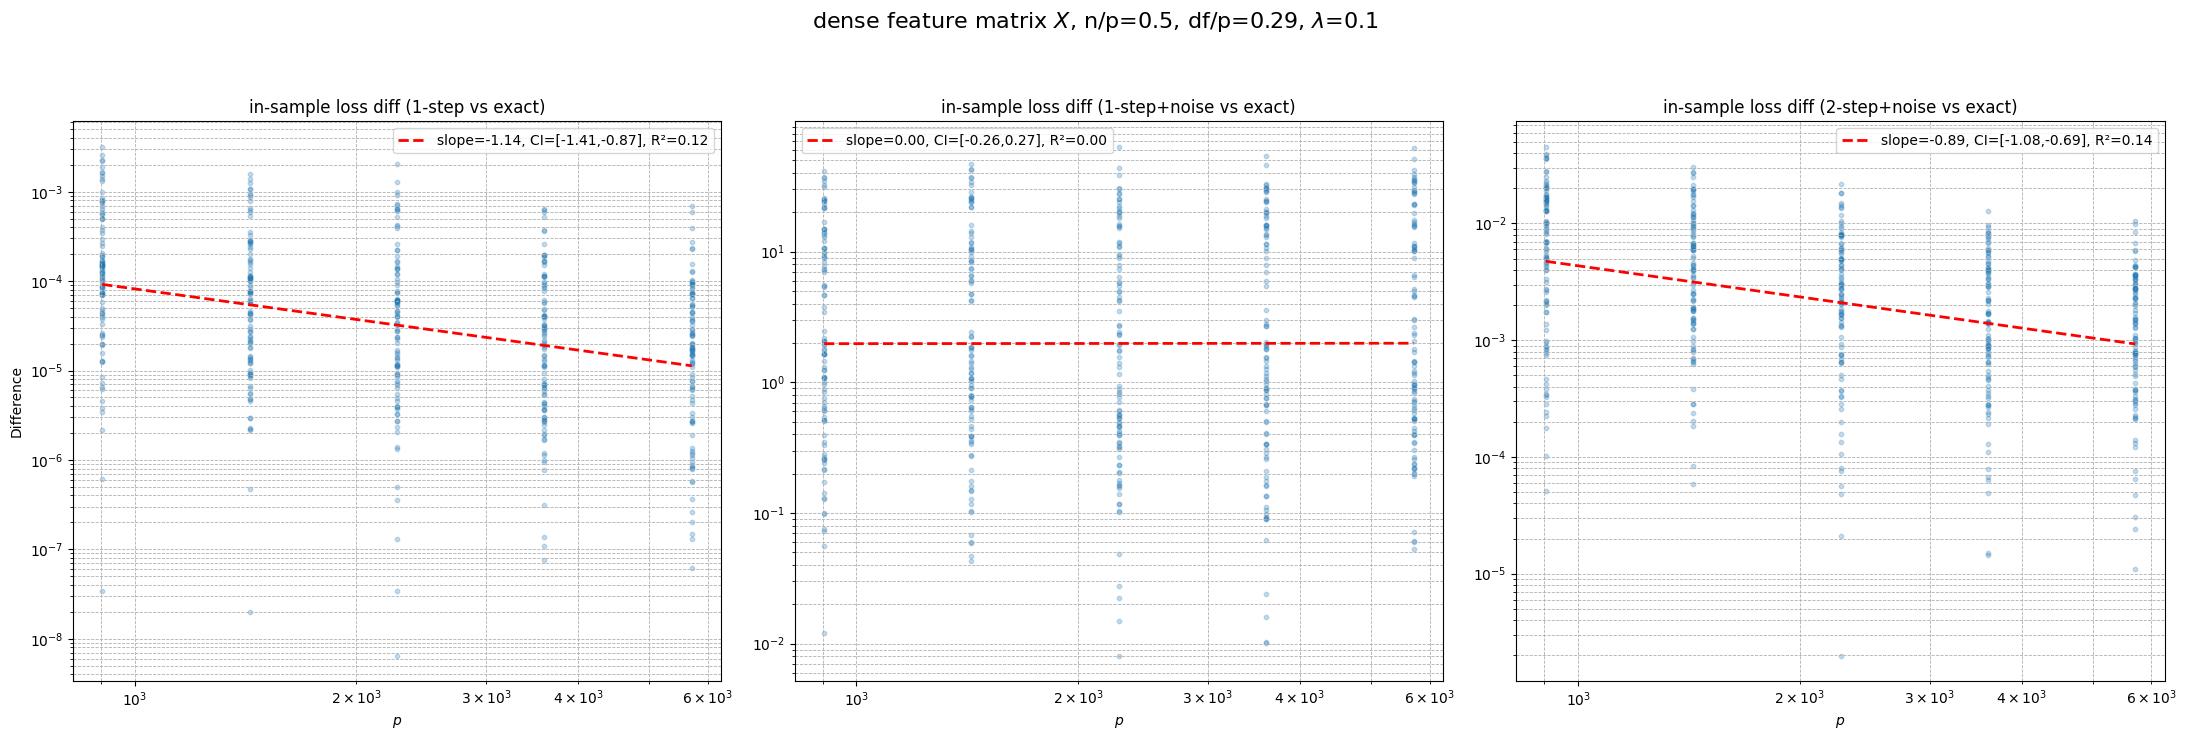

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# ---------------------------------------------------------
# Helper 1: flatten observations into (p, value) pairs
# ---------------------------------------------------------
def flatten_by_p(matrix, p_vals):
    p_vals = np.asarray(p_vals)
    n_p = len(p_vals)

    if matrix.ndim == 3:
        nn, n_new, _ = matrix.shape
        flat = matrix.reshape(nn * n_new, n_p)
    else:
        flat = matrix

    x_long = np.repeat(p_vals, flat.shape[0])
    y_long = flat.T.reshape(-1)
    return x_long, y_long


# ---------------------------------------------------------
# Helper 2: scatter + log-log regression
# ---------------------------------------------------------
def add_scatter_and_regression(ax, p_vals, diff_matrix):
    x, y = flatten_by_p(diff_matrix, p_vals)

    mask = (x > 0) & (y > 0)
    x = x[mask]
    y = y[mask]

    ax.scatter(x, y, alpha=0.25, s=10)

    X_log = np.log(x)
    y_log = np.log(y)
    X_design = sm.add_constant(X_log)
    model = sm.OLS(y_log, X_design).fit()

    slope = model.params[1]
    ci_low, ci_high = model.conf_int()[1]
    R2 = model.rsquared

    p_plot = np.linspace(p_vals.min(), p_vals.max(), 400)
    y_pred = np.exp(model.predict(sm.add_constant(np.log(p_plot))))

    ax.plot(
        p_plot, y_pred, 'r--', lw=2,
        label=f'slope={slope:.2f}, CI=[{ci_low:.2f},{ci_high:.2f}], R²={R2:.2f}'
    )
    ax.legend()


# ---------------------------------------------------------
# FIRST ROW — 1×3 FIGURE
# ---------------------------------------------------------
titles = [
    "in-sample loss diff (1-step vs exact)",
    "in-sample loss diff (1-step+noise vs exact)",
    "in-sample loss diff (2-step+noise vs exact)"
]

fig, axes = plt.subplots(1, 3, figsize=(22, 7))

# 1. In-sample Loss (Exact)
in_sample_diff1_noiseless = np.abs(loss_tilde_noiseless - loss_hat)
add_scatter_and_regression(axes[0], p_, in_sample_diff1_noiseless)
axes[0].set_title(titles[0])
axes[0].set_xlabel(r'$p$')
axes[0].set_ylabel(r'Difference')

# 2. In-sample diff (1 step)
in_sample_diff1 = np.abs(loss_tilde - loss_hat)
add_scatter_and_regression(axes[1], p_, in_sample_diff1)
axes[1].set_title(titles[1])
axes[1].set_xlabel(r'$p$')
#axes[1].set_ylabel(r'Difference')

# 3. In-sample diff (2 step)
in_sample_diff2 = np.abs(loss_tilde_2 - loss_hat)
add_scatter_and_regression(axes[2], p_, in_sample_diff2)
axes[2].set_title(titles[2])
axes[2].set_xlabel(r'$p$')
#axes[2].set_ylabel(r'Difference')

# Styling
for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which='both', linestyle='--', linewidth=0.6)

if sparse:
    fig.suptitle(
        rf'sparse feature matrix $X$, n/p={n/p:.1f}, df/p={tr_H:.2f}, $\lambda$={lambda_}',
        fontsize=16,
        y=1.05
    )
else:
    fig.suptitle(
        rf'dense feature matrix $X$, n/p={n/p:.1f}, df/p={tr_H:.2f}, $\lambda$={lambda_}',
        fontsize=16,
        y=1.05
    )


plt.tight_layout()
plt.show()


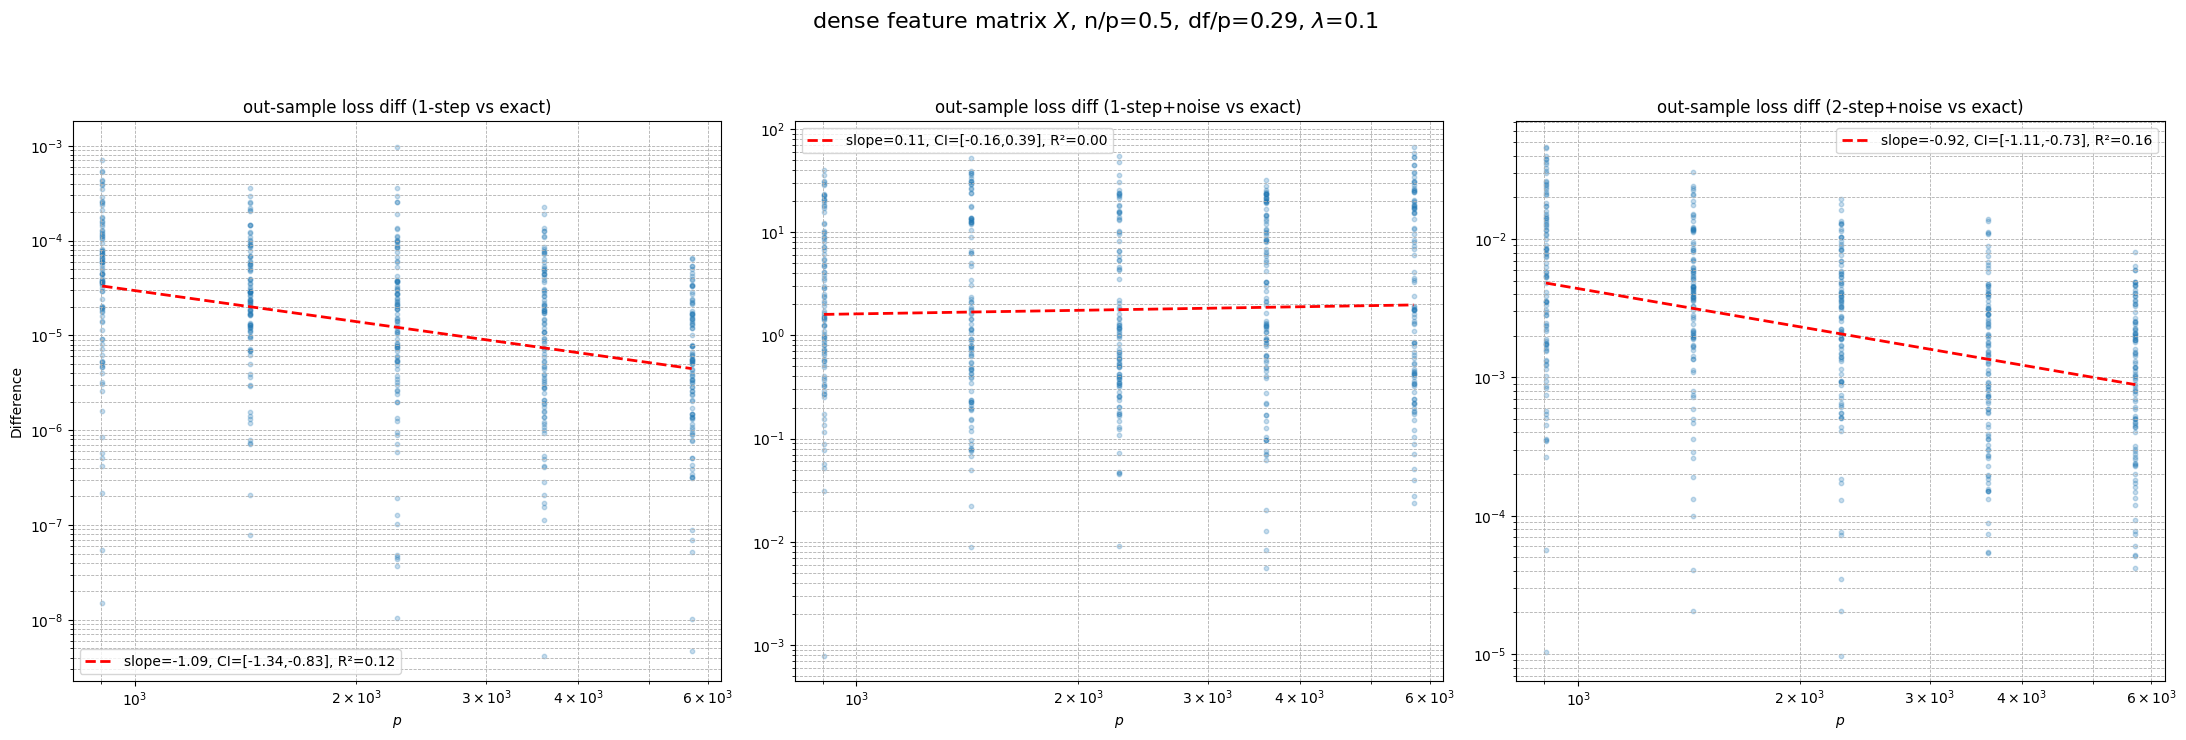

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# ---------------------------------------------------------
# Helper 1: flatten observations into (p, value) pairs
# ---------------------------------------------------------
def flatten_by_p(matrix, p_vals):
    p_vals = np.asarray(p_vals)
    n_p = len(p_vals)

    if matrix.ndim == 3:
        nn, n_new, _ = matrix.shape
        flat = matrix.reshape(nn * n_new, n_p)
    else:
        flat = matrix

    x_long = np.repeat(p_vals, flat.shape[0])
    y_long = flat.T.reshape(-1)
    return x_long, y_long


# ---------------------------------------------------------
# Helper 2: scatter + log-log regression
# ---------------------------------------------------------
def add_scatter_and_regression(ax, p_vals, diff_matrix):
    x, y = flatten_by_p(diff_matrix, p_vals)

    mask = (x > 0) & (y > 0)
    x = x[mask]
    y = y[mask]

    ax.scatter(x, y, alpha=0.25, s=10)

    X_log = np.log(x)
    y_log = np.log(y)
    X_design = sm.add_constant(X_log)
    model = sm.OLS(y_log, X_design).fit()

    slope = model.params[1]
    ci_low, ci_high = model.conf_int()[1]
    R2 = model.rsquared

    p_plot = np.linspace(p_vals.min(), p_vals.max(), 400)
    y_pred = np.exp(model.predict(sm.add_constant(np.log(p_plot))))

    ax.plot(
        p_plot, y_pred, 'r--', lw=2,
        label=f'slope={slope:.2f}, CI=[{ci_low:.2f},{ci_high:.2f}], R²={R2:.2f}'
    )
    ax.legend()


# ---------------------------------------------------------
# The 1×3 LAST ROW FIGURE
# ---------------------------------------------------------
titles = [
    "out-sample loss diff (1-step vs exact)",
    "out-sample loss diff (1-step+noise vs exact)",
    "out-sample loss diff (2-step+noise vs exact)"
]

fig, axes = plt.subplots(1, 3, figsize=(22, 7))

# 1. Out-of-sample raw loss
in_sample_diff1_new_noiseless = np.abs(loss_new_tilde_noiseless - loss_new_hat)
add_scatter_and_regression(axes[0], p_, in_sample_diff1_new_noiseless)
axes[0].set_title(titles[0])
axes[0].set_xlabel(r'$p$')
axes[0].set_ylabel(r'Difference')

# 2. Out-of-sample diff (1 step)
out_sample_diff1 = np.abs(loss_new_tilde - loss_new_hat)
add_scatter_and_regression(axes[1], p_, out_sample_diff1)
axes[1].set_title(titles[1])
axes[1].set_xlabel(r'$p$')
#axes[1].set_ylabel(r'Difference')

# 3. Out-of-sample diff (2 step)
out_sample_diff2 = np.abs(loss_new_tilde_2 - loss_new_hat)
add_scatter_and_regression(axes[2], p_, out_sample_diff2)
axes[2].set_title(titles[2])
axes[2].set_xlabel(r'$p$')
#axes[2].set_ylabel(r'Difference')

# Styling
for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which='both', linestyle='--', linewidth=0.6)

if sparse:
    fig.suptitle(
        rf'sparse feature matrix $X$, n/p={n/p:.1f}, df/p={tr_H:.2f}, $\lambda$={lambda_}',
        fontsize=16,
        y=1.05
    )
else:
    fig.suptitle(
        rf'dense feature matrix $X$, n/p={n/p:.1f}, df/p={tr_H:.2f}, $\lambda$={lambda_}',
        fontsize=16,
        y=1.05
    )


plt.tight_layout()
plt.show()



Error Summary Table:
   p  Mean Error Tilde  SD Tilde  Mean Error Tilde 2   SD Tilde 2  Mean Error Hat   SD Hat
 904          0.006191  0.000606        3.800575e-06 7.838512e-07        1.395297 0.068636
1433          0.004741  0.000448        1.779940e-06 3.741226e-07        1.343042 0.064795
2271          0.003916  0.000403        1.011412e-06 2.266634e-07        1.386057 0.067004
3600          0.003292  0.000366        6.516729e-07 1.683644e-07        1.380139 0.073933
5705          0.002453  0.000200        2.161767e-07 3.369584e-08        1.396313 0.062172

Regression Results (log error vs. log p):
Tilde     Slope: -0.487,  CI: (-0.568, -0.406),  R²: 0.992
Tilde 2   Slope: -1.609,  CI: (-2.098, -1.121),  R²: 0.973
Hat       Slope: 0.007,  CI: (-0.032, 0.045),  R²: 0.096


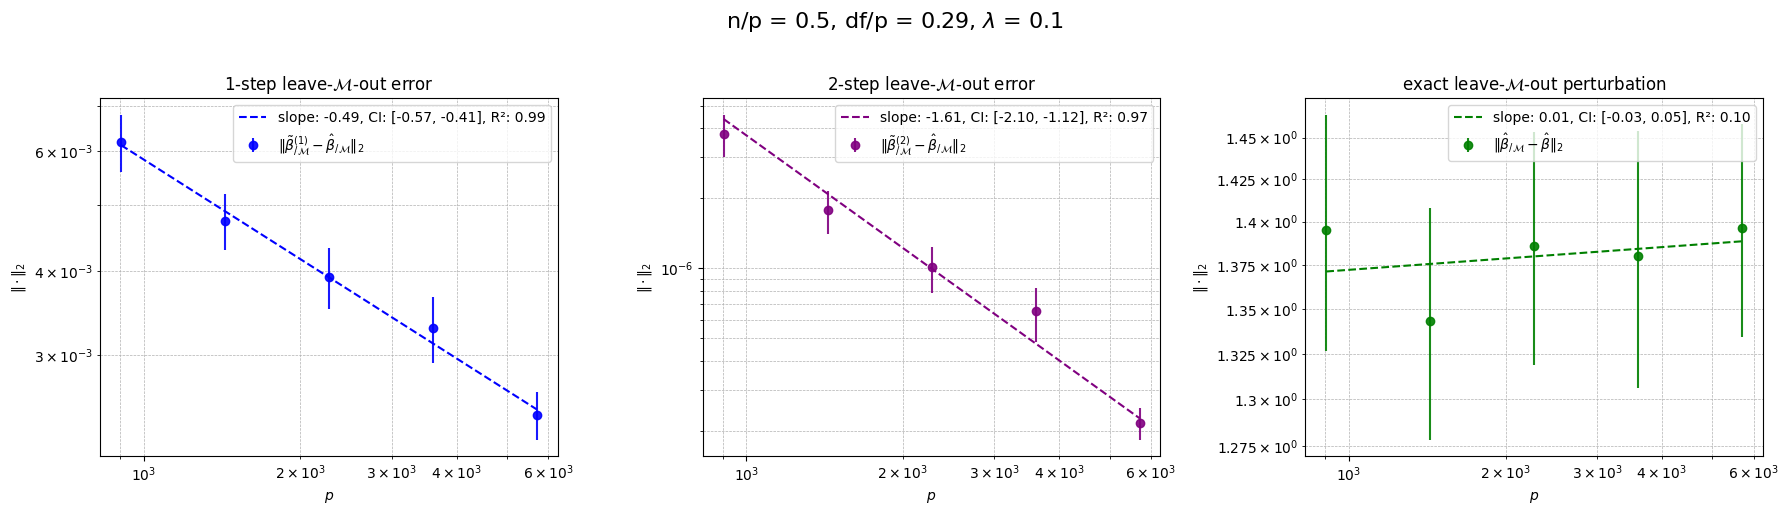

In [ ]:
# Re-import necessary libraries
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

# Ensure p_, meanErr_*, and sdErr_* are all defined by this point

# Construct summary DataFrame
error_table = pd.DataFrame({
    'p': p_,
    'Mean Error Tilde': meanErr_tilde,
    'SD Tilde': sdErr_tilde,
    'Mean Error Tilde 2': meanErr_tilde_2,
    'SD Tilde 2': sdErr_tilde_2,
    'Mean Error Hat': meanErr_hat,
    'SD Hat': sdErr_hat
})

# Print the table in a readable format
print("\nError Summary Table:")
print(error_table.to_string(index=False))

# Log-transform mean errors and p values
log_p = np.log(p_)
log_meanErr_tilde   = np.log(meanErr_tilde)
log_meanErr_tilde_2 = np.log(meanErr_tilde_2)
log_meanErr_hat     = np.log(meanErr_hat)

# Prepare regression design matrix
X_reg = sm.add_constant(log_p)

# Weighted linear regressions
model_tilde    = sm.WLS(log_meanErr_tilde,   X_reg, weights=1 / sdErr_tilde).fit()
model_tilde_2  = sm.WLS(log_meanErr_tilde_2, X_reg, weights=1 / sdErr_tilde_2).fit()
model_hat      = sm.WLS(log_meanErr_hat,     X_reg, weights=1 / sdErr_hat).fit()

# Extract regression results
def extract_model_info(model):
    slope     = model.params[1]
    conf_int  = model.conf_int()[1]
    r_squared = model.rsquared
    return slope, conf_int, r_squared

slope_tilde,   conf_int_tilde,   R2_tilde   = extract_model_info(model_tilde)
slope_tilde_2, conf_int_tilde_2, R2_tilde_2 = extract_model_info(model_tilde_2)
slope_hat,     conf_int_hat,     R2_hat     = extract_model_info(model_hat)

# Print regression summaries
print("\nRegression Results (log error vs. log p):")
print(f"Tilde     Slope: {slope_tilde:.3f},  CI: ({conf_int_tilde[0]:.3f}, {conf_int_tilde[1]:.3f}),  R²: {R2_tilde:.3f}")
print(f"Tilde 2   Slope: {slope_tilde_2:.3f},  CI: ({conf_int_tilde_2[0]:.3f}, {conf_int_tilde_2[1]:.3f}),  R²: {R2_tilde_2:.3f}")
print(f"Hat       Slope: {slope_hat:.3f},  CI: ({conf_int_hat[0]:.3f}, {conf_int_hat[1]:.3f}),  R²: {R2_hat:.3f}")

# Optionally, predictions for plotting
log_error_pred_tilde    = model_tilde.predict(X_reg)
log_error_pred_tilde_2  = model_tilde_2.predict(X_reg)
log_error_pred_hat      = model_hat.predict(X_reg)


# Create a 1x3 panel plot with true log-log scale and error bars
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Titles including parameters
title_text = f"n/p={delta},  df/p={tr_H:.2f}, λ={lambda_}"

# --- Plot 1: Tilde (1-step approximation error)
axes[0].errorbar(p_, meanErr_tilde, yerr=sdErr_tilde, fmt='o',
                 color='blue', alpha=0.9, label=r'$\|\tilde{\beta}^{(1)}_{/ \mathcal{M}} - \hat{\beta}_{/ \mathcal{M}}\|_2$')
axes[0].plot(p_, np.exp(log_error_pred_tilde),
             label=f'slope: {slope_tilde:.2f}, CI: [{conf_int_tilde[0]:.2f}, {conf_int_tilde[1]:.2f}], R²: {R2_tilde:.2f}',
             color='blue', linestyle='--')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel(r'$p$')
axes[0].set_ylabel(r'$\|\cdot\|_2$')
axes[0].set_title(r'1-step leave-$\mathcal{M}$-out error' )
axes[0].legend()
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# --- Plot 2: Tilde 2 (2-step approximation error)
axes[1].errorbar(p_, meanErr_tilde_2, yerr=sdErr_tilde_2, fmt='o',
                 color='purple', alpha=0.9, label=r'$\|\tilde{\beta}^{(2)}_{/ \mathcal{M}} - \hat{\beta}_{/ \mathcal{M}}\|_2$')
axes[1].plot(p_, np.exp(log_error_pred_tilde_2),
             label=f'slope: {slope_tilde_2:.2f}, CI: [{conf_int_tilde_2[0]:.2f}, {conf_int_tilde_2[1]:.2f}], R²: {R2_tilde_2:.2f}',
             color='purple', linestyle='--')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel(r'$p$')
axes[1].set_ylabel(r'$\|\cdot\|_2$')
axes[1].set_title(r'2-step leave-$\mathcal{M}$-out error' )
axes[1].legend()
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# --- Plot 3: Hat (true leave-M-out perturbation)
axes[2].errorbar(p_, meanErr_hat, yerr=sdErr_hat, fmt='o',
                 color='green', alpha=0.9, label=r'$\|\hat{\beta}_{/ \mathcal{M}} - \hat{\beta}\|_2$')
axes[2].plot(p_, np.exp(log_error_pred_hat),
             label=f'slope: {slope_hat:.2f}, CI: [{conf_int_hat[0]:.2f}, {conf_int_hat[1]:.2f}], R²: {R2_hat:.2f}',
             color='green', linestyle='--')
axes[2].set_xscale('log')
axes[2].set_yscale('log')
axes[2].set_xlabel(r'$p$')
axes[2].set_ylabel(r'$\|\cdot\|_2$')
axes[2].set_title(r'exact leave-$\mathcal{M}$-out perturbation' )
axes[2].legend()
axes[2].grid(True, which='both', linestyle='--', linewidth=0.5)

fig.suptitle(rf'n/p = {n/p:.1f}, df/p = {tr_H:.2f}, $\lambda$ = {lambda_}', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()


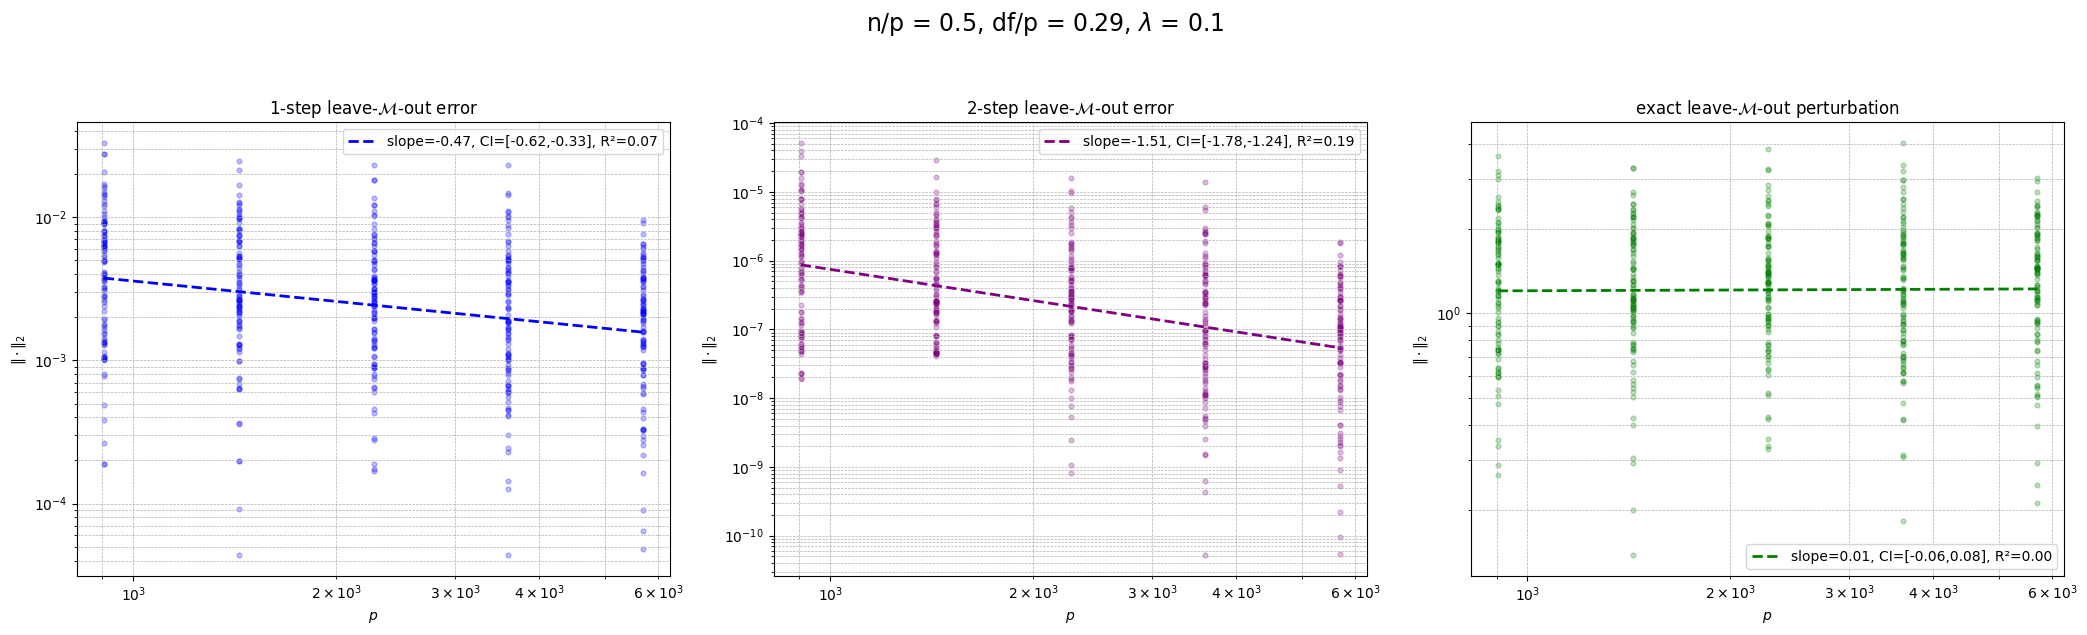

In [ ]:
# Re-import necessary libraries
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd


# ---------------------------------------------------------
# Helper: flatten all raw data for regression + scatter
# ---------------------------------------------------------
def flatten_by_p(matrix, p_vals):
    """
    matrix shape = (nn, n_p)
    returns long x = p repeated, and y = flattened errors
    """
    nn, n_p = matrix.shape
    x = np.repeat(p_vals, nn)
    y = matrix.T.reshape(-1)
    return x, y


# ---------------------------------------------------------
# Raw matrices (these must exist)
#   err_tilde    shape (nn, n_p)
#   err_tilde2   shape (nn, n_p)
#   err_hat      shape (nn, n_p)
# ---------------------------------------------------------

raw_list = [err_tilde, err_tilde_2, err_hat]
titles = [
    r'1-step leave-$\mathcal{M}$-out error',
    r'2-step leave-$\mathcal{M}$-out error',
    r'exact leave-$\mathcal{M}$-out perturbation'
]
colors = ["blue", "purple", "green"]


# ---------------------------------------------------------
# Function to compute regression ON ALL RAW POINTS
# ---------------------------------------------------------
def fit_full_regression(raw_mat, p_vals):
    x_raw, y_raw = flatten_by_p(raw_mat, p_vals)
    mask = (x_raw > 0) & (y_raw > 0)
    x_raw = x_raw[mask]
    y_raw = y_raw[mask]

    log_x = np.log(x_raw)
    log_y = np.log(y_raw)

    X_design = sm.add_constant(log_x)
    model = sm.OLS(log_y, X_design).fit()

    slope = model.params[1]
    ci_low, ci_high = model.conf_int()[1]
    R2 = model.rsquared

    return model, slope, (ci_low, ci_high), R2


# ---------------------------------------------------------
# Compute the three regressions (tilde, tilde2, hat)
# ---------------------------------------------------------
models   = []
slopes   = []
CIs      = []
R2s      = []

for raw_mat in raw_list:
    model, slope, CI, R2 = fit_full_regression(raw_mat, p_)
    models.append(model)
    slopes.append(slope)
    CIs.append(CI)
    R2s.append(R2)


# ---------------------------------------------------------
# 1×3 Plot
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

for ax, raw_mat, model, slope, CI, R2, title, col in zip(
    axes, raw_list, models, slopes, CIs, R2s, titles, colors):

    # Scatter ALL raw points
    x_raw, y_raw = flatten_by_p(raw_mat, p_)
    mask = (x_raw > 0) & (y_raw > 0)
    ax.scatter(
        x_raw[mask], y_raw[mask],
        s=12, alpha=0.25, color=col
    )

    # Regression line evaluated on log(p)
    log_p_eval = np.log(p_)
    pred_log = model.predict(sm.add_constant(log_p_eval))
    pred_y = np.exp(pred_log)

    ax.plot(
        p_, pred_y,
        color=col, linestyle='--', linewidth=2,
        label=f'slope={slope:.2f}, CI=[{CI[0]:.2f},{CI[1]:.2f}], R²={R2:.2f}'
    )

    # Formatting
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$p$')
    ax.set_ylabel(r'$\|\cdot\|_2$')
    ax.set_title(title)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()

fig.suptitle(
    rf'n/p = {n/p:.1f}, df/p = {tr_H:.2f}, $\lambda$ = {lambda_}',
    fontsize=17,
    y=1.05
)

plt.tight_layout()
plt.show()
